In [4]:
!pip install keras-tuner

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import regularizers, layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import random
import os
import keras_tuner as kt
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

In [6]:
data = pd.read_csv('/content/insurance.csv')

In [7]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


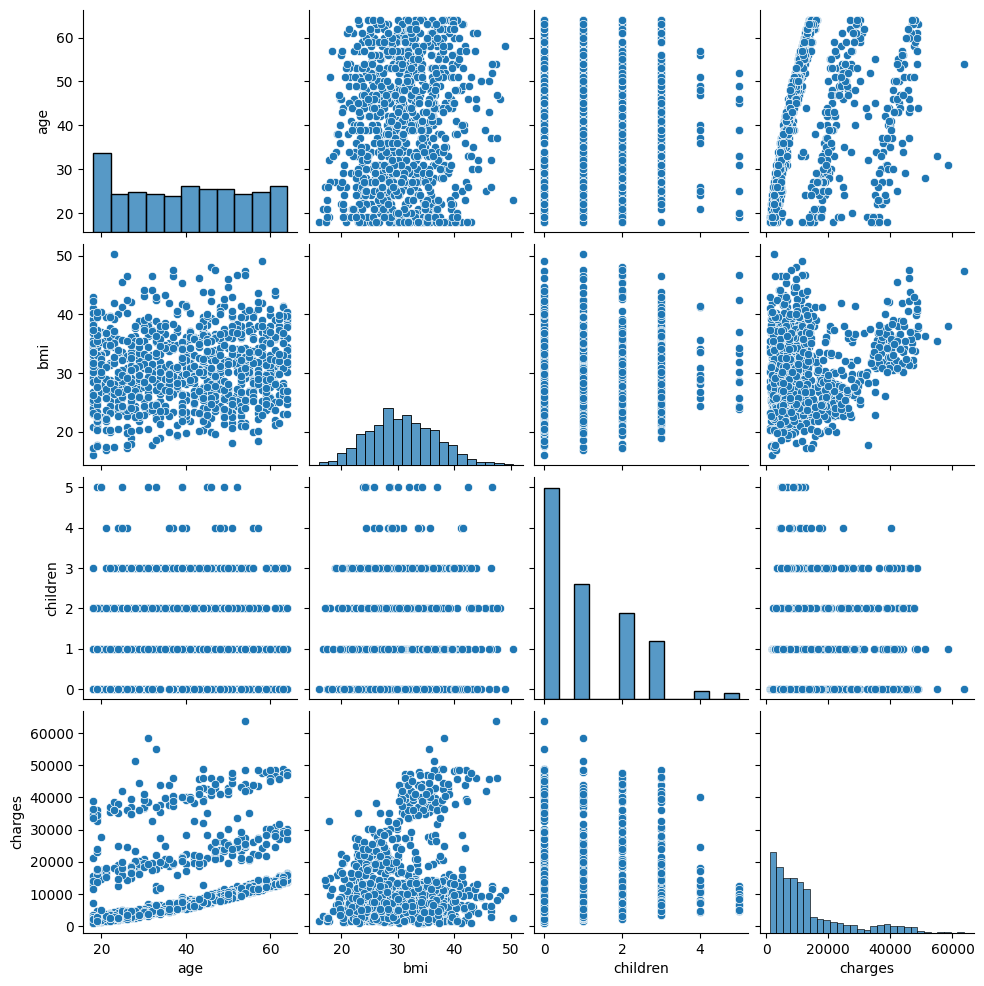

In [8]:
sns.pairplot(data)
plt.show()

In [9]:
data.isna().sum().sum()

0

In [10]:
print(data)

     age     sex     bmi  children smoker     region      charges
0     19  female  27.900         0    yes  southwest  16884.92400
1     18    male  33.770         1     no  southeast   1725.55230
2     28    male  33.000         3     no  southeast   4449.46200
3     33    male  22.705         0     no  northwest  21984.47061
4     32    male  28.880         0     no  northwest   3866.85520
..   ...     ...     ...       ...    ...        ...          ...
995   39  female  23.275         3     no  northeast   7986.47525
996   39  female  34.100         3     no  southwest   7418.52200
997   63  female  36.850         0     no  southeast  13887.96850
998   33  female  36.290         3     no  northeast   6551.75010
999   36  female  26.885         0     no  northwest   5267.81815

[1000 rows x 7 columns]


In [11]:
duplicate_data = data[data.duplicated(keep=False)]
print(duplicate_data)

     age   sex    bmi  children smoker     region    charges
195   19  male  30.59         0     no  northwest  1639.5631
581   19  male  30.59         0     no  northwest  1639.5631


In [12]:
cleaned_data = data.drop_duplicates()
print(cleaned_data)

     age     sex     bmi  children smoker     region      charges
0     19  female  27.900         0    yes  southwest  16884.92400
1     18    male  33.770         1     no  southeast   1725.55230
2     28    male  33.000         3     no  southeast   4449.46200
3     33    male  22.705         0     no  northwest  21984.47061
4     32    male  28.880         0     no  northwest   3866.85520
..   ...     ...     ...       ...    ...        ...          ...
995   39  female  23.275         3     no  northeast   7986.47525
996   39  female  34.100         3     no  southwest   7418.52200
997   63  female  36.850         0     no  southeast  13887.96850
998   33  female  36.290         3     no  northeast   6551.75010
999   36  female  26.885         0     no  northwest   5267.81815

[999 rows x 7 columns]


In [13]:
data = cleaned_data

In [14]:
# Statistical measures for charges

skewness = skew(data['charges'])
print(f'Skewness: {skewness}')

Skewness: 1.527688259892171


In [15]:
# Statistical measures for bmi

skewness = skew(data['bmi'])
print(f'Skewness: {skewness}')

Skewness: 0.23340290502291808


In [16]:
# Statistical measures for age

skewness = skew(data['age'])
print(f'Skewness: {skewness}')

Skewness: 0.02495828922758391


In [17]:
# IQR

Q1 = data[['age', 'charges']].quantile(0.25)
Q3 = data[['age', 'charges']].quantile(0.75)
IQR = Q3 - Q1
print("\nQ1:\n", Q1)
print("\nQ3:\n", Q3)
print("\nIQR:\n", IQR)

outliers = data[((data[['age', 'charges']] < (Q1 - 1.5 * IQR)) | (data[['age', 'charges']] > (Q3 + 1.5 * IQR))).any(axis=1)]
print(outliers)



Q1:
 age          27.000000
charges    4729.002375
Name: 0.25, dtype: float64

Q3:
 age           52.000000
charges    15944.891875
Name: 0.75, dtype: float64

IQR:
 age           25.0000
charges    11215.8895
dtype: float64
     age     sex    bmi  children smoker     region     charges
14    27    male  42.13         0    yes  southeast  39611.7577
19    30    male  35.30         0    yes  southwest  36837.4670
23    34  female  31.92         1    yes  northeast  37701.8768
29    31    male  36.30         2    yes  southwest  38711.0000
30    22    male  35.60         0    yes  southwest  35585.5760
..   ...     ...    ...       ...    ...        ...         ...
947   37    male  34.20         1    yes  northeast  39047.2850
951   51    male  42.90         2    yes  southeast  47462.8940
953   44    male  30.20         2    yes  southwest  38998.5460
956   54    male  30.80         1    yes  southeast  41999.5200
958   43    male  34.96         1    yes  northeast  41034.2214

[107 

Calculation of charges outliner

*   Lower bound: Q1 - 1.5 * IQR = 4729.002375 - 1.5 * 11215.8895 = -12264.834875

*   Upper bound: Q3 + 1.5 * IQR = 15944.891875 + 1.5 * 11215.8895 = 32794.724625



In [18]:
#Clamping

def clamp_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    data[column] = np.where(data[column] < lower_bound, lower_bound, data[column])
    data[column] = np.where(data[column] > upper_bound, upper_bound, data[column])

    return data

# Clamp outliers 'charges'
clamped_data = clamp_outliers_iqr(data.copy(), 'charges')
print(clamped_data)

     age     sex     bmi  children smoker     region      charges
0     19  female  27.900         0    yes  southwest  16884.92400
1     18    male  33.770         1     no  southeast   1725.55230
2     28    male  33.000         3     no  southeast   4449.46200
3     33    male  22.705         0     no  northwest  21984.47061
4     32    male  28.880         0     no  northwest   3866.85520
..   ...     ...     ...       ...    ...        ...          ...
995   39  female  23.275         3     no  northeast   7986.47525
996   39  female  34.100         3     no  southwest   7418.52200
997   63  female  36.850         0     no  southeast  13887.96850
998   33  female  36.290         3     no  northeast   6551.75010
999   36  female  26.885         0     no  northwest   5267.81815

[999 rows x 7 columns]


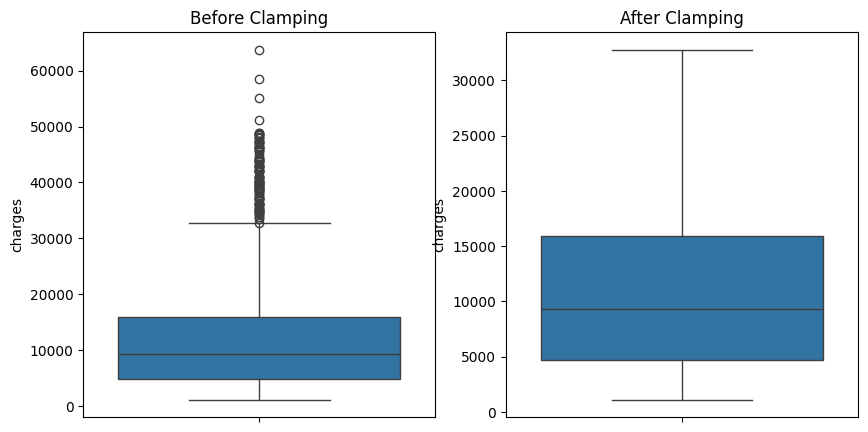

In [19]:
# Before clamping
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=data['charges'])
plt.title("Before Clamping")

# After clamping
plt.subplot(1, 2, 2)
sns.boxplot(y=clamped_data['charges'])
plt.title("After Clamping")

plt.show()

In [20]:
skewness = skew(clamped_data['charges'])
print(f'Skewness: {skewness}')

Skewness: 1.0290406855287897


In [21]:
clamped_data['charges'] = np.log(clamped_data['charges'])

skewness = skew(clamped_data['charges'])
print(f'Skewness: {skewness}')

Skewness: -0.2559955627423052


In [22]:
data['charges'] = np.log(data['charges'])

skewness = skew(data['charges'])
print(f'Skewness: {skewness}')

Skewness: -0.09254709857438813


Data with log transformation has lesser skew value than log transformation + clamping

So we will be considering the non clamped data



In [23]:
data['sex'] = data['sex'].astype('category').cat.codes
data['smoker'] = data['smoker'].astype('category').cat.codes
data['region'] = data['region'].astype('category').cat.codes

In [24]:
print(data)

     age  sex     bmi  children  smoker  region   charges
0     19    0  27.900         0       1       3  9.734176
1     18    1  33.770         1       0       2  7.453302
2     28    1  33.000         3       0       2  8.400538
3     33    1  22.705         0       0       1  9.998092
4     32    1  28.880         0       0       1  8.260197
..   ...  ...     ...       ...     ...     ...       ...
995   39    0  23.275         3       0       0  8.985505
996   39    0  34.100         3       0       3  8.911735
997   63    0  36.850         0       0       2  9.538778
998   33    0  36.290         3       0       0  8.787487
999   36    0  26.885         0       0       1  8.569372

[999 rows x 7 columns]


In [25]:
def reset_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

reset_seeds()

In [26]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [27]:
y = data['charges']
X = data.drop('charges', axis=1)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [29]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Neural Network

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(6,)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

In [31]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mse'])

In [32]:
early_stopping = EarlyStopping(monitor='val_mse', patience=40, mode='max', verbose=1)

In [33]:
model.fit(X_train, y_train, epochs=38, batch_size=4, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/38
180/180 [==============================] - 4s 10ms/step - loss: 20.4056 - mse: 20.2817 - val_loss: 1.6735 - val_mse: 1.5470
Epoch 2/38
180/180 [==============================] - 2s 9ms/step - loss: 2.7149 - mse: 2.5903 - val_loss: 1.1212 - val_mse: 0.9987
Epoch 3/38
180/180 [==============================] - 3s 14ms/step - loss: 1.8572 - mse: 1.7368 - val_loss: 0.6460 - val_mse: 0.5273
Epoch 4/38
180/180 [==============================] - 2s 10ms/step - loss: 1.7019 - mse: 1.5861 - val_loss: 0.6219 - val_mse: 0.5083
Epoch 5/38
180/180 [==============================] - 2s 9ms/step - loss: 1.2537 - mse: 1.1421 - val_loss: 0.7765 - val_mse: 0.6675
Epoch 6/38
180/180 [==============================] - 2s 8ms/step - loss: 1.0746 - mse: 0.9678 - val_loss: 0.7101 - val_mse: 0.6058
Epoch 7/38
180/180 [==============================] - 1s 6ms/step - loss: 0.8020 - mse: 0.6996 - val_loss: 0.4480 - val_mse: 0.3478
Epoch 8/38
180/180 [==============================] - 2s 8ms/step - los

In [34]:
test_loss, test_mse = model.evaluate(X_test, y_test)
print("Mean Squared Error:", test_mse)

7/7 [==============================] - 0s 4ms/step - loss: 0.1525 - mse: 0.1396
Mean Squared Error: 0.1395673304796219


HyperParameter Tunining for Neural Networks

In [35]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=512, step=32),
                    activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(rate=hp.Float('dropout_input', min_value=0.0, max_value=0.5, step=0.1)))

    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
                        activation='relu'))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Dense(1, activation='linear'))

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mse'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=75,
    executions_per_trial=2,
    directory='my_dir',
    project_name='insurance_nn_fine_tuning'
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_mse', patience=10)])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_mse', patience=10)])

Trial 75 Complete [00h 00m 18s]
val_mse: 0.15540067851543427

Best val_mse So Far: 0.07897715270519257
Total elapsed time: 00h 28m 52s
Epoch 1/50
20/20 [==============================] - 2s 29ms/step - loss: 37.6167 - mse: 37.6167 - val_loss: 3.6982 - val_mse: 3.6982
Epoch 2/50
20/20 [==============================] - 0s 13ms/step - loss: 4.4686 - mse: 4.4686 - val_loss: 2.4907 - val_mse: 2.4907
Epoch 3/50
20/20 [==============================] - 0s 13ms/step - loss: 2.5003 - mse: 2.5003 - val_loss: 1.8699 - val_mse: 1.8699
Epoch 4/50
20/20 [==============================] - 0s 12ms/step - loss: 1.8680 - mse: 1.8680 - val_loss: 1.5461 - val_mse: 1.5461
Epoch 5/50
20/20 [==============================] - 0s 14ms/step - loss: 1.5226 - mse: 1.5226 - val_loss: 1.2551 - val_mse: 1.2551
Epoch 6/50
20/20 [==============================] - 0s 12ms/step - loss: 1.2734 - mse: 1.2734 - val_loss: 1.0407 - val_mse: 1.0407
Epoch 7/50
20/20 [==============================] - 0s 7ms/step - loss: 1.090

In [36]:
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]

trial_id = best_trial.trial_id

best_val_mse = best_trial.metrics.get_best_value('val_mse')

print(f"Mean Squared Error: {best_val_mse}")

Mean Squared Error: 0.07897715270519257


Linear Regression

In [37]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

predictions = linear_reg.predict(X_test)

mse_linear_reg = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse_linear_reg)

Mean Squared Error: 0.1853652466483362


Decision Tree Regression

In [38]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

predictions = tree_reg.predict(X_test)

mse_tree_reg = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse_tree_reg)

Mean Squared Error: 0.16115641205252693


HyperParameter Turning for Decision Tree

In [39]:
param_dist = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

random_search = RandomizedSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                                   param_distributions=param_dist, n_iter=100,
                                   cv=3, n_jobs=-1, scoring='neg_mean_squared_error')

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_model = random_search.best_estimator_

print("Best parameters: ", best_params)
print("Best estimator: ", best_model)

predictions = best_model.predict(X_test)
mse_tree_reg = mean_squared_error(y_test, predictions)
print("Mean Squared Error: ", mse_tree_reg)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters:  {'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': None}
Best estimator:  DecisionTreeRegressor(min_samples_leaf=10, random_state=42)
Mean Squared Error:  0.1504996042032123


Random Forest Regression

In [40]:
forest_reg = RandomForestRegressor(n_estimators=100)
forest_reg.fit(X_train, y_train)

predictions = forest_reg.predict(X_test)

mse_forest_reg = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse_forest_reg)

Mean Squared Error: 0.15369645873871834


HyperParameter Turning for Random Forest Regression

In [41]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 6, 8],
    'criterion': ['squared_error', 'absolute_error']
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid, cv=3, n_jobs=-1,
                           scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters: ", best_params)
print("Best estimator: ", best_model)

predictions = best_model.predict(X_test)
mse_forest_reg = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse_forest_reg)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
54 fits failed out of a total of 162.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

Best parameters:  {'criterion': 'absolute_error', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 300}
Best estimator:  RandomForestRegressor(criterion='absolute_error', max_depth=8,
                      max_features='sqrt', n_estimators=300, random_state=42)
Mean Squared Error: 0.14202160935358346


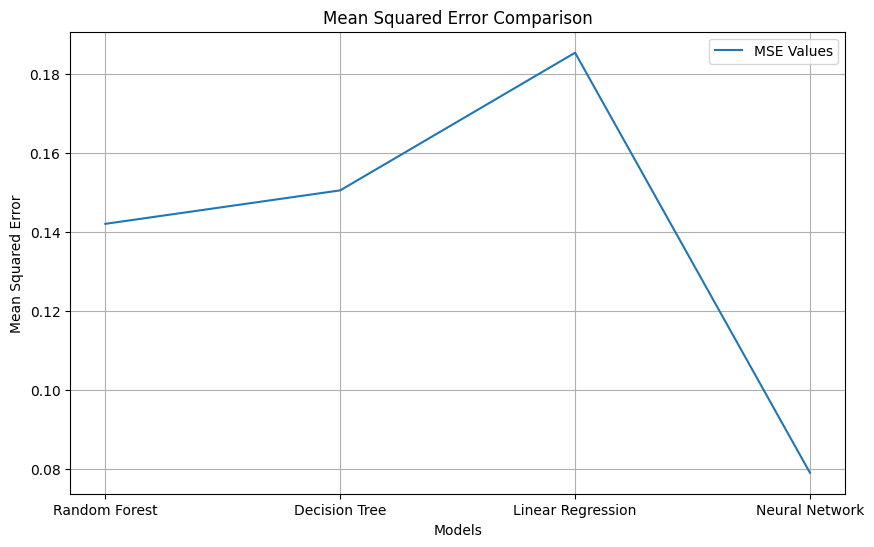

In [42]:
mse_values = [mse_forest_reg, mse_tree_reg, mse_linear_reg, best_val_mse]
model_names = ['Random Forest', 'Decision Tree', 'Linear Regression', 'Neural Network']

plt.figure(figsize=(10, 6))
plt.plot(model_names, mse_values, label='MSE Values')
plt.title('Mean Squared Error Comparison')
plt.xlabel('Models')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.legend()
plt.show()

Among the 4 models

*   Neural Network performs the best - MSE - 0.07897715270519257

*   Random Forest - 2nd - MSE - 0.15369645873871834

*   Decision Tree - 3rd - MSE - 0.1504996042032123

*   Linear Regression - 4th - MSE -  0.1853652466483362

Why Neural Network performed the best : Best result 

* They are very adaptable to various types of data.
* Regularization and dropout feature prevents data from overfitting.
* They are very good in handling non-linear and complex data



We can see that, age vs charges and bmi vs charges scatter plot that shows non-linearity, which shows why neural network performs the best



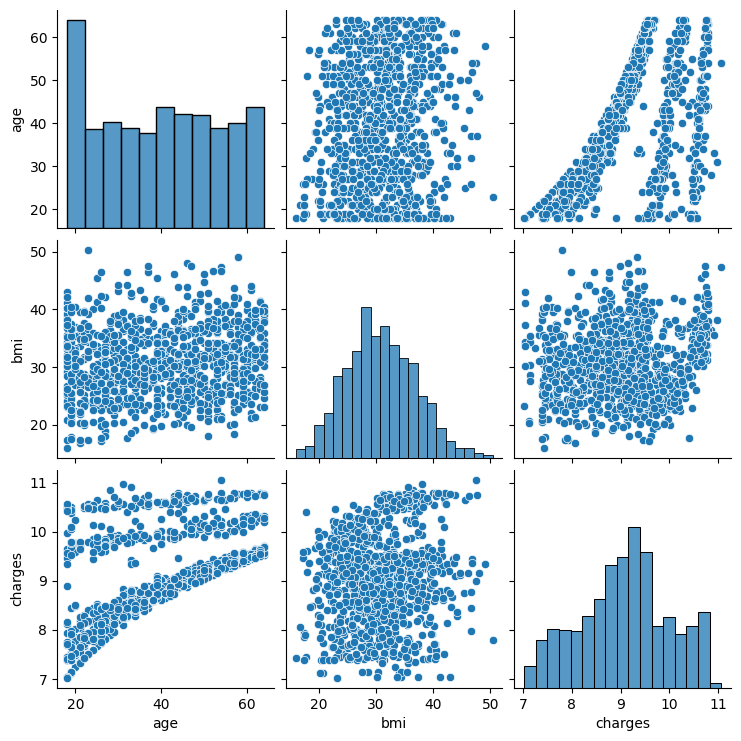

In [43]:
subset_data = data[['age', 'bmi', 'charges']]

sns.pairplot(subset_data)
plt.show()

2nd Random Forest and 3rd Decision Tree

* Random forest work by combining multiple decision trees, which can produce better generalization and robustness compared to decision tree.

* Random forest are insensivite to outliners.

* Probablity of overfitting is less for random forest.


* Probablity of overfitting is less for random forest
Decision trees can easily overfit to the training data, leading to poor performance on the test set.

* High Sensitivity

* Probablity of overfitting is less for random forest.

4th - Linear Regression
* In the scatter plot we can see that, there are many data points that do not lie near the red line
* We can see the data is clustered with gaps in between, which means there exist a more complex relationship that linear reg cannot understand
* For higher values the prediction goes wrong



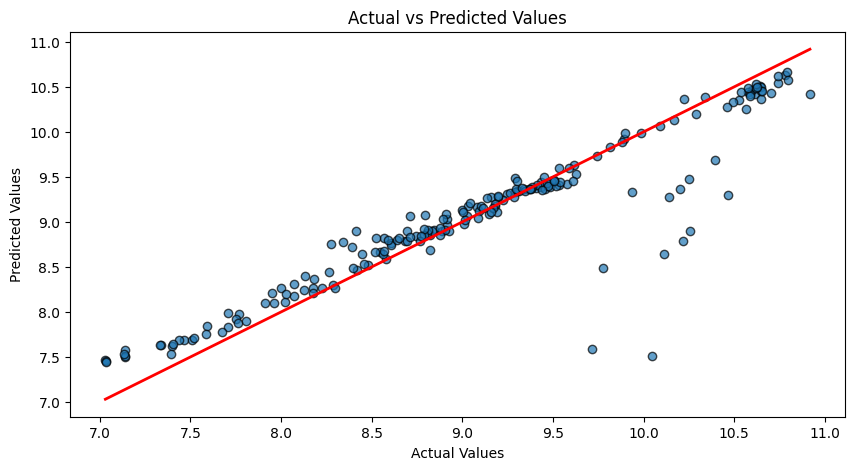

In [44]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, predictions, edgecolor='k', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

Fitted values or predicted values are plotted along with residual

We can see a slight curve, which says the relationship between the dependent and independent variable is not linear

There are potential outliners

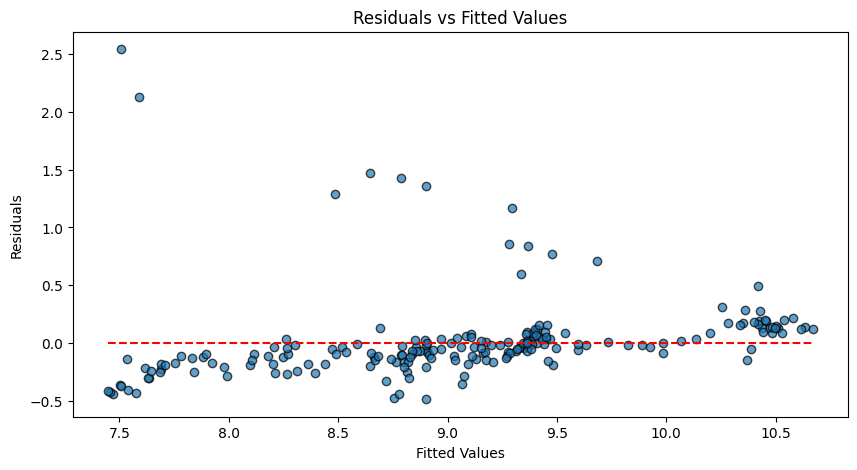

In [45]:
residuals = y_test - predictions

plt.figure(figsize=(10, 5))
plt.scatter(predictions, residuals, edgecolor='k', alpha=0.7)
plt.hlines(y=0, xmin=min(predictions), xmax=max(predictions), colors='red', linestyles='dashed')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()